In [6]:
import matplotlib
import uproot, uproot3
import numpy
import numba
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange
import ROOT
import os,sys
from array import array

from Lumi import *
from TDR_Style import *
from Ratio_Plot import *

In [7]:
@numba.njit
def sgn(num):
    if (num >= 0):
        return 1
    else:
        return -1

### 1. Template Distribution

In [8]:
def AddHist_FTdist(file, branch, hist_pre1, hist_pre2, isData, xsec):
    
    if isData:
        print('is Data')
        init_branches = ['is_lepton_tight','jet_pt','mt','met','lepton_pt','lepton_eta','lepton_pdgid','lepton_pfRelIso04_all',
                                                       'HLT_IsoMu24','HLT_Mu8_TrkIsoVVL','HLT_Mu17_TrkIsoVVL','hlt',
                                                      'HLT_Ele8_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30']
        if not (branch in init_branches):
            init_branches.append(branch)
        branches = uproot.open(file+':Events').arrays(init_branches, library='pd')

    else:
        print('is MC')
        init_branches = ['is_lepton_tight','jet_pt','mt','met','lepton_pt','lepton_eta','lepton_pdgid','lepton_pfRelIso04_all','lepton_gen_matching','gen_weight',
                                                       'HLT_IsoMu24','HLT_Mu8_TrkIsoVVL','HLT_Mu17_TrkIsoVVL','hlt',
                                                      'HLT_Ele8_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30']
        if not (branch in init_branches):
            init_branches.append(branch)
        branches = uproot.open(file+':Events').arrays(init_branches, library='pd')
        true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]

        weight_lowpt = (1000*xsec*0.01485) / true_events
        weight_highpt = (1000*xsec*0.06281) / true_events
        lepton_gen_cut1 = branches.loc[:,'lepton_gen_matching'] == 1
        lepton_gen_cut2 = branches.loc[:,'lepton_gen_matching'] == 15
        
    HLT_cut1 = branches.loc[:,'HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30'] == True
    HLT_cut2 = branches.loc[:,'HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30'] == True
    
    met_cut = branches.loc[:,'met'] < 2000
    mt_cut = branches.loc[:,'mt'] < 20
    lepton_cut = abs(branches.loc[:,'lepton_pdgid']) == 11
#    pf_cut = branches.loc[:,'lepton_pfRelIso04_all'] < 0.4
    pf_cut = branches.loc[:,'is_lepton_tight'] == 0
    pt_edge = branches.loc[:,'lepton_pt'] < 25
    jet_pt = branches.loc[:,'jet_pt'] > 35
    
    if isData:
        arrays_0_25 = branches.loc[HLT_cut1 & lepton_cut & pf_cut & pt_edge & met_cut & mt_cut & jet_pt,:] 
        arrays_25_Inf = branches.loc[HLT_cut2 & lepton_cut & pf_cut & ~pt_edge & met_cut & mt_cut & jet_pt,:] 
        for i in trange(0, len(arrays_0_25[branch]), desc=f'fill pt<25 part for {file}'):
            hist_pre1.Fill(float(arrays_0_25[branch].values[i]))
        for i in trange(0, len(arrays_25_Inf[branch]), desc=f'fill pt>25 part for {file}'):
            hist_pre2.Fill(float(arrays_25_Inf[branch].values[i]))
    
    else:
        if ('TTbar' in file) or ('QCD' in file):
            print ("QCD process\n")
            arrays_0_25 = branches.loc[HLT_cut1 & lepton_cut & pf_cut & pt_edge & met_cut & mt_cut & jet_pt,:] 
            arrays_25_Inf = branches.loc[HLT_cut2 & lepton_cut & pf_cut & ~pt_edge & met_cut & mt_cut & jet_pt,:] 
        else:
            arrays_0_25 = branches.loc[HLT_cut1 & lepton_cut & pf_cut & pt_edge & met_cut & mt_cut & (lepton_gen_cut1 | lepton_gen_cut2) & jet_pt,:] 
            arrays_25_Inf = branches.loc[HLT_cut2 & lepton_cut & pf_cut & ~pt_edge & met_cut & mt_cut & (lepton_gen_cut1 | lepton_gen_cut2) & jet_pt,:] 
        for i in trange(0, len(arrays_0_25[branch]), desc=f'fill pt<25 part for {file}'):
            hist_pre1.Fill(float(arrays_0_25[branch].values[i]), weight_lowpt*sgn(arrays_0_25['gen_weight'].values[i]))
        for i in trange(0, len(arrays_25_Inf[branch]), desc=f'fill pt>25 part for {file}'):
            hist_pre2.Fill(float(arrays_25_Inf[branch].values[i]), weight_highpt*sgn(arrays_25_Inf['gen_weight'].values[i]))
        
    print("DONE")

    return True

### PT dist

In [9]:
xbins = 20
xlow = 0
xup = 200
branch = 'lepton_pt'

ptbins = [10, 13, 16, 20, 24, 28, 35, 45, 200]

# --original
hist_dist1_DATA = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist2_DATA = ROOT.TH1D("","",xbins, xlow, xup)

# --for pt distribution
#hist_dist1_DATA = ROOT.TH1D("","",8, array('d',ptbins))
#hist_dist2_DATA = ROOT.TH1D("","",8, array('d',ptbins))

hist_dist1_DATA.Sumw2()
hist_dist2_DATA.Sumw2()

file_list = [
"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016H.root"
]

for file in file_list:
    AddHist_FTdist(file, branch, hist_dist1_DATA, hist_dist2_DATA, 1, 1)

# --original
hist_dist1_WJets = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist2_WJets = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist1_ZJets = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist2_ZJets = ROOT.TH1D("","",xbins, xlow, xup)

# --for pt 
#hist_dist1_WJets = ROOT.TH1D("","",8, array('d',ptbins))
#hist_dist2_WJets = ROOT.TH1D("","",8, array('d',ptbins))
#hist_dist1_ZJets = ROOT.TH1D("","",8, array('d',ptbins))
#hist_dist2_ZJets = ROOT.TH1D("","",8, array('d',ptbins))

hist_dist1_WJets.Sumw2()
hist_dist2_WJets.Sumw2()
hist_dist1_ZJets.Sumw2()
hist_dist2_ZJets.Sumw2()

file_WJets = "/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root"
file_ZJets = "/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root"
file_ZJets2 = "/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root"


AddHist_FTdist(file_WJets, branch, hist_dist1_WJets, hist_dist2_WJets, 0, 61526.7)
AddHist_FTdist(file_ZJets, branch, hist_dist1_ZJets, hist_dist2_ZJets, 0, 6077.22)
AddHist_FTdist(file_ZJets2, branch, hist_dist1_ZJets, hist_dist2_ZJets, 0, 18610)

# --original
hist_dist1_ttbar = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist2_ttbar = ROOT.TH1D("","",xbins, xlow, xup)

# --for pt
#hist_dist1_ttbar = ROOT.TH1D("","",8, array('d',ptbins))
#hist_dist2_ttbar = ROOT.TH1D("","",8, array('d',ptbins))

hist_dist1_ttbar.Sumw2()
hist_dist2_ttbar.Sumw2()

# -- Electron channel
file_list_QCD = [
"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-15to20_EMEnriched_TuneCP5_13TeV_pythia8_2016.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-20to30_EMEnriched_TuneCP5_13TeV_pythia8_2016.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-30to50_EMEnriched_TuneCP5_13TeV_pythia8_2016.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-50to80_EMEnriched_TuneCP5_13TeV_pythia8_2016.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-80to120_EMEnriched_TuneCP5_13TeV_pythia8_2016.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-120to170_EMEnriched_TuneCP5_13TeV_pythia8_2016.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-170to300_EMEnriched_TuneCP5_13TeV_pythia8_2016.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-300toInf_EMEnriched_TuneCP5_13TeV_pythia8_2016.root"
]






xsec_list_QCD = [
    1327000,
    4908000,
    6396000,
    1989000,
    366500,
    66490,
    16480,
    1097
]



for i in range(len(file_list_QCD)):
    AddHist_FTdist(file_list_QCD[i], branch, hist_dist1_ttbar, hist_dist2_ttbar, 0, xsec_list_QCD[i])

is Data


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016B.root: 100%|██████████| 16070/16070 [00:00<00:00, 164104.87it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016B.root: 100%|██████████| 52691/52691 [00:00<00:00, 178245.88it/s]


DONE
is Data


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016C.root: 100%|██████████| 3998/3998 [00:00<00:00, 145623.41it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016C.root: 100%|██████████| 11540/11540 [00:00<00:00, 145336.44it/s]


DONE
is Data


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016D.root: 100%|██████████| 6546/6546 [00:00<00:00, 169888.89it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016D.root: 100%|██████████| 19271/19271 [00:00<00:00, 165549.26it/s]


DONE
is Data


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016E.root: 100%|██████████| 5217/5217 [00:00<00:00, 134858.18it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016E.root: 100%|██████████| 14932/14932 [00:00<00:00, 134691.40it/s]


DONE
is Data


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016F.root: 100%|██████████| 2767/2767 [00:00<00:00, 175643.42it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016F.root: 100%|██████████| 6056/6056 [00:00<00:00, 174214.89it/s]


DONE
is Data


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016G.root: 100%|██████████| 6188/6188 [00:00<00:00, 144475.79it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016G.root: 100%|██████████| 9576/9576 [00:00<00:00, 173491.43it/s]


DONE
is Data


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016H.root: 100%|██████████| 5895/5895 [00:00<00:00, 132961.69it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016H.root: 100%|██████████| 9003/9003 [00:00<00:00, 167257.18it/s]


DONE
is MC


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 4568/4568 [00:00<00:00, 8792.51it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 5506/5506 [00:00<00:00, 113298.39it/s]


DONE
is MC


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 35776/35776 [00:00<00:00, 68873.61it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 49496/49496 [00:00<00:00, 98017.92it/s] 


DONE
is MC


fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 1008/1008 [00:00<00:00, 99977.73it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 466/466 [00:00<00:00, 106514.75it/s]


DONE
is MC
QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-15to20_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 277/277 [00:00<00:00, 101451.47it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-15to20_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 24/24 [00:00<00:00, 59670.00it/s]

DONE
is MC


QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-20to30_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 1562/1562 [00:00<00:00, 110657.93it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-20to30_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 211/211 [00:00<00:00, 99226.16it/s]

DONE
is MC


QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-30to50_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 5095/5095 [00:00<00:00, 82368.37it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-30to50_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 2891/2891 [00:00<00:00, 70767.12it/s]

DONE
is MC


QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-50to80_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 2756/2756 [00:00<00:00, 71162.11it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-50to80_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 6388/6388 [00:00<00:00, 74865.01it/s]

DONE
is MC


QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-80to120_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 1738/1738 [00:00<00:00, 87973.99it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-80to120_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 7055/7055 [00:00<00:00, 86400.83it/s]

DONE
is MC


QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-120to170_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 1557/1557 [00:00<00:00, 84361.80it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-120to170_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 7322/7322 [00:00<00:00, 84494.69it/s]

DONE
is MC


QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-170to300_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 514/514 [00:00<00:00, 84319.16it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-170to300_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 2574/2574 [00:00<00:00, 84029.07it/s]

DONE
is MC


QCD process



fill pt<25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-300toInf_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 365/365 [00:00<00:00, 72073.86it/s]
fill pt>25 part for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/QCD_Pt-300toInf_EMEnriched_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 1722/1722 [00:00<00:00, 75262.77it/s]

DONE


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


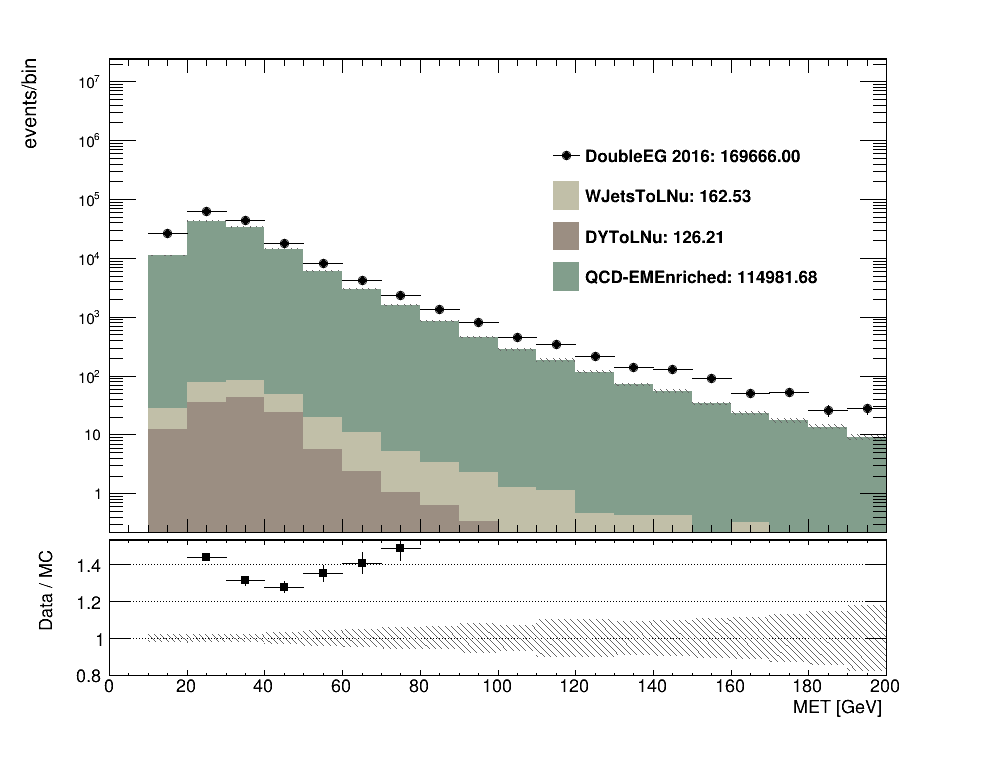

In [10]:
c1 = ROOT.TCanvas("","",1000,800)

def SetHistStyle_dist(hist, color, isData):
    if isData:
        hist.SetMarkerStyle(20)
        hist.SetMarkerColor(color)
    else:
        hist.SetFillColor(color)
        hist.SetFillStyle(4100)
        hist.SetLineColor(color)
        hist.SetLineStyle(0)
        hist.SetLineWidth(0)
    hist.SetYTitle('events/bin')
    hist.SetXTitle('MET [GeV]')
    # Adjust y-axis settings
    # hist.GetYaxis().SetNdivisions(105)
    hist.GetYaxis().SetTitleSize(25)
    hist.GetYaxis().SetTitleFont(43)
    hist.GetYaxis().SetTitleOffset(1.40)
    hist.GetYaxis().SetLabelFont(43)
    hist.GetYaxis().SetLabelSize(25)

    # Adjust x-axis settings
    hist.GetXaxis().SetTitleSize(25)
    hist.GetXaxis().SetTitleFont(43)
    hist.GetXaxis().SetTitleOffset(5.0)
    hist.GetXaxis().SetLabelFont(43)
    hist.GetXaxis().SetLabelSize(25)
    hist.SetStats(0)


SetHistStyle_dist(hist_dist1_WJets, 22, 0)
SetHistStyle_dist(hist_dist2_WJets, 22, 0)
SetHistStyle_dist(hist_dist1_ZJets, 27, 0)
SetHistStyle_dist(hist_dist2_ZJets, 27, 0)
SetHistStyle_dist(hist_dist1_ttbar, 32, 0)
SetHistStyle_dist(hist_dist2_ttbar, 32, 0)
SetHistStyle_dist(hist_dist1_DATA, 1, 1)
SetHistStyle_dist(hist_dist2_DATA, 1, 1)

hist_dist_WJets = hist_dist1_WJets.Clone()
hist_dist_WJets.Add(hist_dist2_WJets)
SetHistStyle_dist(hist_dist_WJets, 22, 0)
hist_dist_ZJets = hist_dist1_ZJets.Clone()
hist_dist_ZJets.Add(hist_dist2_ZJets)
SetHistStyle_dist(hist_dist_ZJets, 27, 0)
hist_dist_ttbar = hist_dist1_ttbar.Clone()
hist_dist_ttbar.Add(hist_dist2_ttbar)
SetHistStyle_dist(hist_dist_ttbar, 32, 0)

hs_dist = ROOT.THStack("",";M_{T,e} [GeV];events/bin")
hs_dist.Add(hist_dist_ZJets)
hs_dist.Add(hist_dist_WJets)
hs_dist.Add(hist_dist_ttbar)

# --original
MC_err = ROOT.TH1D("","",xbins,xlow,xup)
# --for PT
#MC_err = ROOT.TH1D("","",8,array('d',ptbins))
MC_err.Sumw2()
MC_err.Add(hist_dist1_WJets)
MC_err.Add(hist_dist2_WJets)
MC_err.Add(hist_dist1_ZJets)
MC_err.Add(hist_dist2_ZJets)
MC_err.Add(hist_dist1_ttbar)
MC_err.Add(hist_dist2_ttbar)
MC_err.SetFillColor(ROOT.kGray+2)
MC_err.SetFillStyle(3345)
MC_err.SetMarkerSize(0.)
MC_err.SetMarkerColor(ROOT.kGray+2)
MC_err.SetLineWidth(2)
MC_err.SetLineColor(0)
MC_err.SetStats(0)

# --originral
hs_data = ROOT.TH1D("","",xbins,xlow,xup)
# --for PT
#hs_data = ROOT.TH1D("","",8,array('d',ptbins))

hs_data.Add(hist_dist1_DATA)
hs_data.Add(hist_dist2_DATA)
SetHistStyle_dist(hs_data, 1, 1)

legend = ROOT.TLegend(0.55, 0.45, 0.70, 0.75)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.035)
legend.SetLineWidth(1)
legend.SetLineStyle(0)
# legend.AddEntry(hist_dist1_DATA,'Double Muon 2018')
legend.AddEntry(hist_dist1_DATA,f'DoubleEG 2016: {format(hs_data.GetSumOfWeights(), ".2f")}')
legend.AddEntry(hist_dist1_WJets,f'WJetsToLNu: {format(hist_dist_WJets.GetSumOfWeights(), ".2f")}','F')
legend.AddEntry(hist_dist1_ZJets,f'DYToLNu: {format(hist_dist_ZJets.GetSumOfWeights(), ".2f")}','F')
legend.AddEntry(hist_dist1_ttbar,f'QCD-EMEnriched: {format(hist_dist_ttbar.GetSumOfWeights(), ".2f")}','F')

c1.Draw()
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.015)  # joins upper and lower plot
# pad1.SetGridx()
pad1.Draw()
# Lower ratio plot is pad2
c1.cd()  # returns to main canvas before defining pad2
pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
pad2.SetTopMargin(0)  # joins upper and lower plot
pad2.SetBottomMargin(0.3)
pad2.SetGridy()
pad2.Draw()

# draw everything
pad1.cd()
# hs_data.GetYaxis().SetMaxDigits(3)
hs_dist.Draw("HIST")
hs_dist.SetMaximum(10000000)
hs_dist.SetMinimum(1)
# hs_dist.GetXaxis().SetRangeUser(10,60)
hs_dist.GetXaxis().SetLabelSize(0)
hs_data.Draw("ep SAME")
MC_err.Draw("e2 SAME")
legend.Draw("SAME")
ROOT.gPad.SetLogy()
ROOT.gPad.RedrawAxis()


# h1.GetXaxis().SetLabelSize(0)
pad2.cd()
h3 = createRatio(hs_data, MC_err)
h4 = createRatio(MC_err, MC_err)
h3.Draw("ep")
# h3.GetXaxis().SetRangeUser(10,60)
h4.Draw("e2 SAME")
ROOT.gPad.RedrawAxis()

#CMS_lumi(pad1, 0, 0)
# c1.SaveAs('Fake_Lepton/2017/eta_TightElectron_dist_MR_2017_new.pdf')
# c1.SaveAs('Fake_Lepton/2017/eta_TightElectron_dist_MR_2017_new.png')
#c1.SaveAs('Fake_Lepton/2017/MET_FakeElectron_dist_MR_2017_new.pdf')
#c1.SaveAs('Fake_Lepton/2017/MET_FakeElectron_dist_MR_2017_new.png')

## SF

SF from MT

In [11]:
bin_left = hist_dist1_WJets.FindBin(0)
bin_right = hist_dist1_WJets.FindBin(20)

WJets_yields = hist_dist1_WJets.Integral(bin_left,bin_right) + hist_dist2_WJets.Integral(bin_left,bin_right)
ZJets_yields = hist_dist1_ZJets.Integral(bin_left,bin_right) + hist_dist2_ZJets.Integral(bin_left,bin_right)
ttbar_yields = hist_dist1_ttbar.Integral(bin_left,bin_right) + hist_dist2_ttbar.Integral(bin_left,bin_right)
data_yields = hist_dist1_DATA.Integral(bin_left,bin_right) + hist_dist2_DATA.Integral(bin_left,bin_right)

print (hist_dist1_WJets.FindBin(0),hist_dist1_WJets.FindBin(20))
print (f"WJets yields in EWK CR: {WJets_yields}")
print (f"ZJets yields in EWK CR: {ZJets_yields}")
print (f"QCD yields in EWK CR: {ttbar_yields}")
print (f"data yields in EWK CR: {data_yields}")
print (f"SF = {data_yields} / {WJets_yields + ZJets_yields + ttbar_yields}  = {data_yields/(WJets_yields+ZJets_yields+ttbar_yields)}")
SF = data_yields/(WJets_yields+ZJets_yields+ttbar_yields)

1 3
WJets yields in EWK CR: 58.87083707674219
ZJets yields in EWK CR: 47.761675513467665
QCD yields in EWK CR: 54132.75121905787
data yields in EWK CR: 88372.0
SF = 88372.0 / 54239.38373164808  = 1.6292957979984555


sf from lepton PT

SF : 35-45 1.4075984808852136
SF Err: 35-45 0.05492079416249972
SF : 45-Inf 1.4860414815013736
SF Err: 45-Inf 0.06727541765079931


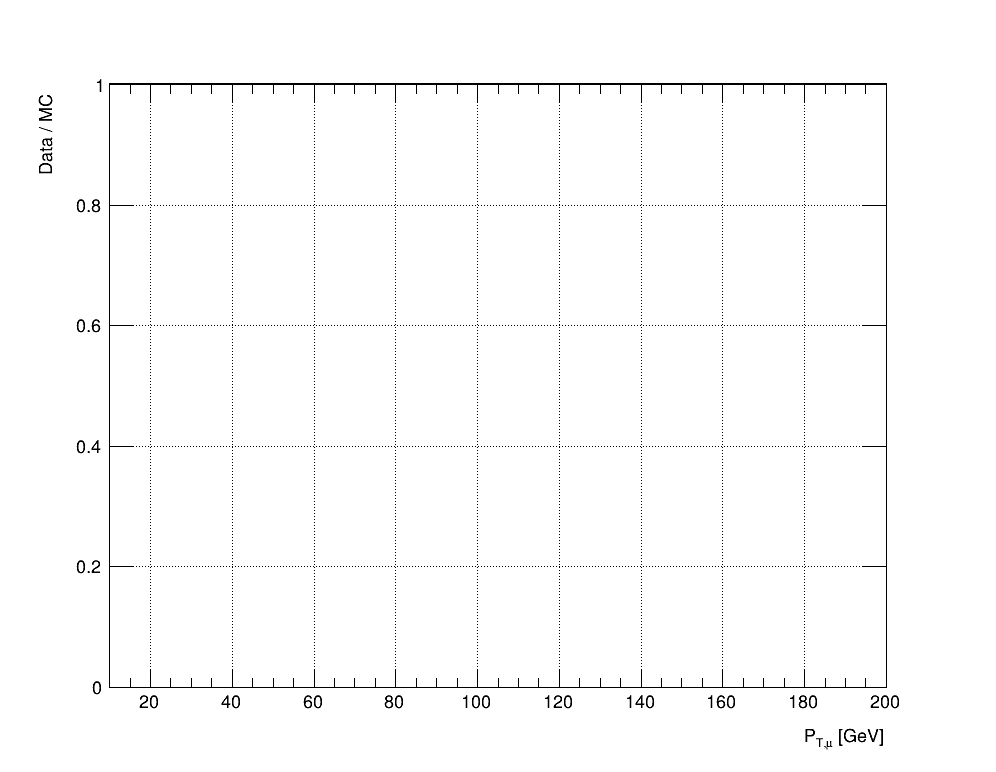

In [12]:
c1 = ROOT.TCanvas("","",1000,800)
c1.Draw()


h3.Draw('ep')
h3.SetXTitle('P_{T,#mu} [GeV]')
h3.GetXaxis().SetTitleOffset(1.6)
h3.GetXaxis().SetRangeUser(10,200)
h3.SetMaximum(1)
h3.SetMinimum(0)
ROOT.gPad.SetGridy()
ROOT.gPad.SetGridx()

print("SF : 35-45",h3.GetBinContent(7))
print("SF Err: 35-45",h3.GetBinError(7))
print("SF : 45-Inf",h3.GetBinContent(8))
print("SF Err: 45-Inf",h3.GetBinError(8))

## Electron Fake Rate

In [13]:
def AddHist_FR_Ele(file, h_nume_e, h_deno_e, isAdd, isData, lumi_Ele12, lumi_Ele23, xsec):
    
    if isData:
        print('is Data')
        branches = uproot.open(file+':Events').arrays(['jet_pt','is_lepton_tight','mt','met','lepton_pt','lepton_eta','lepton_pdgid','HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30','hlt'], library='pd')
    else:
        print('is MC')
        branches = uproot.open(file+':Events').arrays(['jet_pt','is_lepton_tight','mt','met','lepton_pt','lepton_eta','lepton_pdgid',
                                                       'lepton_gen_matching','HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30','hlt','gen_weight'], library='pd')
        true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]
        weight_lowpt = (1000*lumi_Ele12*xsec*isAdd) / true_events
        weight_highpt = (1000*lumi_Ele23*xsec*isAdd) / true_events
        lepton_gen_cut1 = branches.loc[:,'lepton_gen_matching'] == 1
        lepton_gen_cut2 = branches.loc[:,'lepton_gen_matching'] == 15
        
    HLT_cut1 = branches.loc[:,'HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30'] == True
    HLT_cut2 = branches.loc[:,'HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30'] == True
    met_cut = branches.loc[:,'met'] < 20
    mt_cut = branches.loc[:,'mt'] < 20
    Electron_cut = abs(branches.loc[:,'lepton_pdgid']) == 11
    pt_edge = branches.loc[:,'lepton_pt'] < 25
    jet_pt = branches.loc[:,'jet_pt'] >35

    
    overflow_Y = h_deno_e.GetYaxis().GetBinUpEdge(h_deno_e.GetNbinsY())
    center_upper_Y = h_deno_e.GetYaxis().GetBinCenter(h_deno_e.GetNbinsY())
    
    if isData:
        deno_e_lowpt = branches.loc[HLT_cut1 & pt_edge & Electron_cut & met_cut & mt_cut & jet_pt,:]
        deno_e_highpt = branches.loc[HLT_cut2 & ~pt_edge & Electron_cut & met_cut & mt_cut & jet_pt,:]
        
        
        for i in trange(0, len(deno_e_lowpt['lepton_pt']), desc=f'fill pt < 25 GeV for {file}'):
            if float(deno_e_lowpt['lepton_pt'].values[i]) < overflow_Y:
                h_deno_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), float(deno_e_lowpt['lepton_pt'].values[i]))
                if deno_e_lowpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), float(deno_e_lowpt['lepton_pt'].values[i]))
            else:
                h_deno_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), center_upper_Y)
                if deno_e_lowpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), center_upper_Y)
                
        for i in trange(0, len(deno_e_highpt['lepton_pt']), desc=f'fill pt > 25 GeV for {file}'):
            if float(deno_e_highpt['lepton_pt'].values[i]) < overflow_Y:
                h_deno_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), float(deno_e_highpt['lepton_pt'].values[i]))
                if deno_e_highpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), float(deno_e_highpt['lepton_pt'].values[i]))
            else:
                h_deno_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), center_upper_Y)
                if deno_e_highpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), center_upper_Y)
                    
                
    else:
        deno_e_lowpt = branches.loc[HLT_cut1 & pt_edge & Electron_cut & met_cut & mt_cut & (lepton_gen_cut1 | lepton_gen_cut2) & jet_pt,:].copy()
        deno_e_highpt = branches.loc[HLT_cut2 & ~pt_edge & Electron_cut & met_cut & mt_cut & (lepton_gen_cut1 | lepton_gen_cut2) & jet_pt,:].copy()
        
        # Add SF
        deno_e_highpt.loc[:,'SF'] = 1
        deno_e_highpt.loc[(deno_e_highpt['lepton_pt'] >= 35) & (deno_e_highpt['lepton_pt'] < 45), 'SF'] = 1
        deno_e_highpt.loc[deno_e_highpt['lepton_pt'] >= 45 , 'SF'] = 1
        
        
        for i in trange(0, len(deno_e_lowpt['lepton_pt']), desc=f'fill pt < 25 GeV for {file}'):
            if float(deno_e_lowpt['lepton_pt'].values[i]) < overflow_Y:
                h_deno_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), float(deno_e_lowpt['lepton_pt'].values[i]), weight_lowpt*sgn(deno_e_lowpt['gen_weight'].values[i]))
                if deno_e_lowpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), float(deno_e_lowpt['lepton_pt'].values[i]), weight_lowpt*sgn(deno_e_lowpt['gen_weight'].values[i]))
            else:
                h_deno_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), center_upper_Y, weight_lowpt*sgn(deno_e_lowpt['gen_weight'].values[i]))
                if deno_e_lowpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_lowpt['lepton_eta'].values[i])), center_upper_Y, weight_lowpt*sgn(deno_e_lowpt['gen_weight'].values[i]))
                
        for i in trange(0, len(deno_e_highpt['lepton_pt']), desc=f'fill pt > 25 GeV for {file}'):
            if float(deno_e_highpt['lepton_pt'].values[i]) < overflow_Y:
                h_deno_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), float(deno_e_highpt['lepton_pt'].values[i]), deno_e_highpt['SF'].values[i]*weight_highpt*sgn(deno_e_highpt['gen_weight'].values[i]))
                if deno_e_highpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), float(deno_e_highpt['lepton_pt'].values[i]), deno_e_highpt['SF'].values[i]*weight_highpt*sgn(deno_e_highpt['gen_weight'].values[i]))
            else:
                h_deno_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), center_upper_Y, deno_e_highpt['SF'].values[i]*weight_highpt*sgn(deno_e_highpt['gen_weight'].values[i]))
                if deno_e_highpt['is_lepton_tight'].values[i] == 1:
                    h_nume_e.Fill(abs(float(deno_e_highpt['lepton_eta'].values[i])), center_upper_Y, deno_e_highpt['SF'].values[i]*weight_highpt*sgn(deno_e_highpt['gen_weight'].values[i]))


    deno_counts = 0
    for i in range(h_deno_e.GetNbinsX()):
        for j in range(h_deno_e.GetNbinsY()):
            deno_counts += h_deno_e.GetBinContent(i+1,j+1) 

    nume_counts = 0
    for i in range(h_nume_e.GetNbinsX()):
        for j in range(h_nume_e.GetNbinsY()):
            nume_counts += h_nume_e.GetBinContent(i+1,j+1) 

    print (f"normalized deno :{deno_counts}")
    print (f"normalized nume :{nume_counts}")

Data processing

In [14]:
ybins = [15, 20, 24, 28, 35, 45, 60]
xbins = [.0, 0.5, 1.0, 1.5, 2.0, 2.5]

from array import array
h_deno_e = ROOT.TH2D("","", len(xbins)-1, array('d',xbins), len(ybins)-1, array('d',ybins))
h_deno_e.StatOverflows(1)
h_deno_e.Sumw2()
h_nume_e = ROOT.TH2D("","", len(xbins)-1, array('d',xbins), len(ybins)-1, array('d',ybins))
h_nume_e.StatOverflows(1)
h_nume_e.Sumw2()



file_list_E = [
"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016H.root"
]
for file_DATA in file_list_E:
    AddHist_FR_Ele(file_DATA, h_nume_e, h_deno_e, 1, 1, 0, 0, 0)

is Data


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016B.root: 100%|██████████| 13545/13545 [00:00<00:00, 38740.18it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016B.root: 100%|██████████| 44182/44182 [00:01<00:00, 36063.96it/s]


normalized deno :57612.0
normalized nume :19950.0
is Data


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016C.root: 100%|██████████| 3212/3212 [00:00<00:00, 46324.86it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016C.root: 100%|██████████| 9149/9149 [00:00<00:00, 47649.70it/s]


normalized deno :69956.0
normalized nume :24255.0
is Data


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016D.root: 100%|██████████| 5123/5123 [00:00<00:00, 42725.58it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016D.root: 100%|██████████| 15402/15402 [00:00<00:00, 41383.23it/s]


normalized deno :90454.0
normalized nume :31333.0
is Data


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016E.root: 100%|██████████| 3931/3931 [00:00<00:00, 37439.45it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016E.root: 100%|██████████| 11753/11753 [00:00<00:00, 37708.05it/s]


normalized deno :106115.0
normalized nume :36683.0
is Data


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016F.root: 100%|██████████| 2072/2072 [00:00<00:00, 32215.44it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016F.root: 100%|██████████| 4557/4557 [00:00<00:00, 33353.19it/s]


normalized deno :112730.0
normalized nume :38969.0
is Data


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016G.root: 100%|██████████| 4594/4594 [00:00<00:00, 32277.88it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016G.root: 100%|██████████| 6992/6992 [00:00<00:00, 35714.55it/s]


normalized deno :124298.0
normalized nume :42934.0
is Data


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016H.root: 100%|██████████| 4301/4301 [00:00<00:00, 28935.70it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DoubleEG_Run2016H.root: 100%|██████████| 6728/6728 [00:00<00:00, 44466.14it/s]


normalized deno :135304.0
normalized nume :46885.0


MC processing

In [15]:
file_WJets = "/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root"
file_ZJets = "/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root"
file_ZJets2 = "/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root"


xsec_WJets = 61526.7  
xsec_ZJets = 6077.22 
xsec_ZJets2 = 18610

lumi_Ele12 = 0.01485 # HLT_Ele8_CaloIdL_TrackIdL_IsoVL_PFJet30 2018 lumi
lumi_Ele23 = 0.06281 # HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30 2018 lumi

AddHist_FR_Ele(file_WJets, h_nume_e, h_deno_e, -1, 0, lumi_Ele12, lumi_Ele23, xsec_WJets)
AddHist_FR_Ele(file_ZJets, h_nume_e, h_deno_e, -1, 0, lumi_Ele12, lumi_Ele23, xsec_ZJets)
AddHist_FR_Ele(file_ZJets2, h_nume_e, h_deno_e, -1, 0, lumi_Ele12, lumi_Ele23, xsec_ZJets2)
print (lumi_Ele12, lumi_Ele23, xsec_WJets)
print (lumi_Ele12, lumi_Ele23, xsec_ZJets)
print (lumi_Ele12, lumi_Ele23, xsec_ZJets2)

is MC


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 14272/14272 [00:00<00:00, 22372.07it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 69470/69470 [00:04<00:00, 14686.51it/s]


normalized deno :133502.0613232823
normalized nume :45138.10171761075
is MC


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 159306/159306 [00:07<00:00, 20665.30it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 729952/729952 [00:48<00:00, 15136.53it/s]


normalized deno :132015.59785036757
normalized nume :43703.304945143296
is MC


fill pt < 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 6596/6596 [00:00<00:00, 24592.54it/s]
fill pt > 25 GeV for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakeLepton/FR/merged/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 6857/6857 [00:00<00:00, 15599.46it/s]


normalized deno :131849.65981153844
normalized nume :43544.40247572601
0.01485 0.06281 61526.7
0.01485 0.06281 6077.22
0.01485 0.06281 18610


35.86 fb^{-1} (13 TeV)


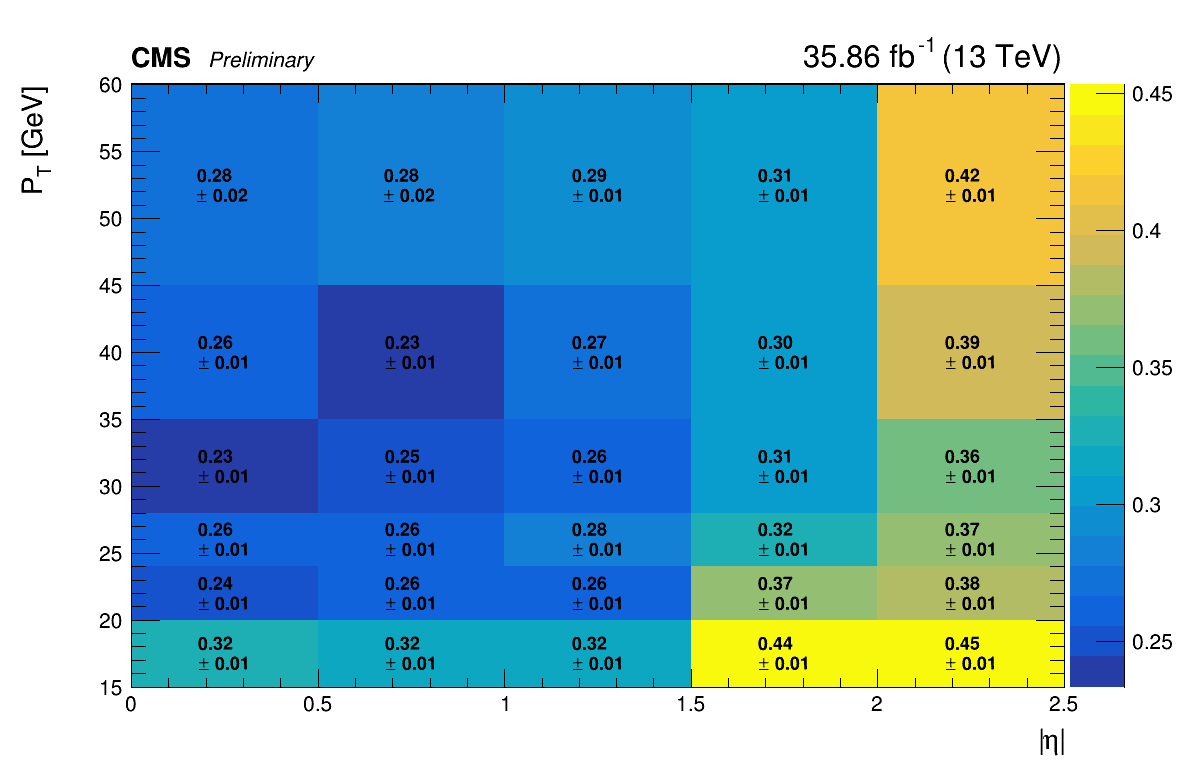

In [16]:
fake_rate_e = h_nume_e.Clone("fake_rate_e")
fake_rate_e.Divide(h_deno_e)

fake_rate_e.SetDirectory(0)
c1 = ROOT.TCanvas("","",1200,800)
fake_rate_e.SetStats(0)
fake_rate_e.SetXTitle("|#eta|")
fake_rate_e.SetYTitle("P_{T} [GeV]")
fake_rate_e.SetMarkerSize(1.3)
ROOT.gStyle.SetPaintTextFormat('4.2f')
fake_rate_e.Draw("COLZe TEXT")
c1.Draw()
CMS_lumi(c1,0,0)
# c1.SaveAs('Fake_Lepton/2017/FR_Electron_data_2017_new.pdf')
# c1.SaveAs('Fake_Lepton/2017/FR_Electron_data_2017_new.png')

In [17]:
file1 = ROOT.TFile("Ele_Fake_Rate_2D_2016.root","recreate")
file1.cd()
fake_rate_e.Write()
file1.Close()

In [18]:
!ls Ele_Fake_Rate_2D_2016.root

Ele_Fake_Rate_2D_2016.root
